In [10]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix,precision_recall_curve
import xgboost as xgb
from xgboost import plot_importance, to_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import graphviz

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

%matplotlib inline

In [2]:
# mod1_yang_file = "/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/model_pred_results/yang-model-1.tsv"
# mod1_yin_file = "/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/model_pred_results/yin-model-1.tsv"
# mod4_yang_file = "/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/model_pred_results/yang-model-4.tsv"
# mod4_yin_file = "/home/hqyone/mnt/2tb/github/MaskRCNN_TF1/samples/hpv_models/data/model_pred_results/yin-model-4.tsv"

mod1_yang_file = "../../data/patent_predict/yang-211-model-T1.tsv"
mod1_yin_file = "../../data/patent_predict/yin-189-model-T1.tsv"
mod4_yang_file = "../../data/patent_predict/yang-211-model-A3.tsv"
mod4_yin_file = "../../data/patent_predict/yin-189-model-A3.tsv"



mod1_yang_df = pd.read_csv(mod1_yang_file, sep='\t')
mod1_yang_df['type']=1
mod1_yin_df = pd.read_csv(mod1_yin_file, sep='\t')
mod1_yin_df['type']=0
mod4_yang_df = pd.read_csv(mod4_yang_file, sep='\t')
mod4_yang_df['type']=1
mod4_yin_df = pd.read_csv(mod4_yin_file, sep='\t')
mod4_yin_df['type']=0

mod1_df = mod1_yang_df.append(mod1_yin_df)
mod4_df = mod4_yang_df.append(mod4_yin_df)

def UpdateDF(df):
    #x = df.drop(columns=['patientID','type'], axis=1)
    x = df
    x['yang_ratio']= x['yang']/(x['yang']+x['yin-yang']+x['yin'])
    x['comb_yang']= x['yang']+x['yin-yang']
    x['yang_ratio2']= (x['yang']+x['yin-yang'])/(x['yang']+x['yin-yang']+x['yin'])  
    return(x)

Total rows: 257, with flag: 120, proportion: 0.4669260700389105


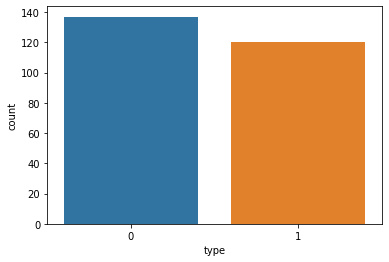

In [3]:
def proportion(df,column,plot=False):
    t=df[column].count()
    c=df[column].sum()
    print(f'Total rows: {t}, with flag: {c}, proportion: {c/t}')
    if plot:
        sns.countplot(x=column, data=df)

proportion(mod1_df,'type', plot=True)        

In [17]:
def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (area = %0.6f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()


def plot_pr(recall,precision,average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: {0:0.6f}'.format(average_precision))
    plt.show()

    
def plot_learning_curve(results,epochs):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='logloss-Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='logloss-Test')
    ax.plot(x_axis, results['validation_0']['auc'], label='auc-Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='auc-Test')
    ax.legend()
    plt.ylabel('Log Loss/AUC')
    plt.title('XGBoost Log Loss and AUC evolution')
    plt.show()


def run_xgboost_and_calculate_auc(df,
                                  target='target',
                                  drop='variable_to_find_and_exclude',
                                  w=1,
                                  plot_learning=False,
                                  plot_variables=False,
                                  plot_ROC_PR=False,
                                  plot_confusion=False,
                                  plot_graph_tree=False,
                                  learning_rate=0.05,
                                  max_depth=10,
                                  esr=10,
                                  CV=True,
                                  title='',
                                  plot_all=False,
                                  ensembler=False,
                                  test_size=.2):
    '''
    Generic function to run xgboost to test the added changes and plot roc, learning and others and save the model.
    '''
    df = UpdateDF(df)
    # features
    X = df.drop(target, axis=1)
    X = pd.get_dummies(X)
    
    # targets
    Y = df[target]
    #X, Y = getXY(df)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=test_size,
                                                        random_state=12345,
                                                        stratify=Y)

    print(f'variables: {len(list(X))}, rows:{len(X)}, flags:{sum(list(df[target]))}')
    
        
    clf = xgb.XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=4,
        gamma=0.6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=5e-05,
        objective='binary:logistic',
        nthread=20,
        scale_pos_weight=w,
        seed=27)

    eval_set = [(X_train, Y_train), (X_test, Y_test)]

    if plot_all:
        plot_learning=True
        plot_variables=True
        plot_ROC_PR=True
        plot_confusion=True
        plot_graph_tree=True
        
    if CV:
        X = pd.concat([X_train,X_test])
        y = pd.concat([Y_train,Y_test])
        xgb_param = clf.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, y.values)
        cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round=clf.get_params()['n_estimators'],
                          nfold=5,
                          metrics='auc',
                          early_stopping_rounds=esr)
        print(cvresult.tail(1))
        clf.set_params(n_estimators=cvresult.shape[0])

    clf.fit(X_train,
            Y_train,
            early_stopping_rounds=25,
            eval_metric=['auc','error','logloss'],
            eval_set=eval_set,
            verbose=False)

    Y_pred = clf.predict_proba(X_test)
    y_true = np.array(Y_test)
    y_scores = Y_pred[:, 1]

    fpr, tpr, _ = roc_curve(Y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(Y_test, y_scores)
    precision, recall, _ = precision_recall_curve(Y_test, y_scores)

    y_train_hat = clf.predict(X_train)
    y_train_hat_probs = clf.predict_proba(X_train)[:,1]
    train_accuracy = accuracy_score(Y_train, y_train_hat)*100
    train_auc_roc = roc_auc_score(Y_train, y_train_hat_probs)*100

    y_test_hat = clf.predict(X_test)
    y_test_hat_probs = clf.predict_proba(X_test)[:,1]
    test_accuracy = accuracy_score(Y_test, y_test_hat)*100
    test_auc_roc = roc_auc_score(Y_test, y_test_hat_probs)*100

    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba)

    plot_roc(fpr, tpr, roc_auc)
    plot_pr(recall,precision,average_precision)
    
    print('Confusion matrix:\n', confusion_matrix(Y_train, y_train_hat))
    print('Training AUC: %.4f %%' % train_auc_roc)
    print('Training accuracy: %.4f %%' % train_accuracy)

    print('Test Confusion matrix:\n', confusion_matrix(Y_test, y_test_hat))
    print('Test Training AUC: %.4f %%' % test_auc_roc)
    print('Test Training accuracy: %.4f %%' % test_accuracy)
    print('Average_precision: %.4f ' % float(average_precision))
    
    if plot_ROC_PR:
        plot_roc(fpr, tpr, roc_auc)
        plot_pr(recall,precision,average_precision)
    else:
        print('Area under ROC: %0.6f' % roc_auc)

    if plot_learning:
        results = clf.evals_result()
        epochs = len(results['validation_0']['error'])

    if plot_variables:
        xgb.plot_importance(clf,max_num_features=20,importance_type='gain',xlabel='gain')

    if plot_confusion:
        print('\n', classification_report(y_true, y_scores.round()))

    if plot_graph_tree:
        xgb.plot_tree(clf, rankdir='LR')
        fig = plt.gcf()
        fig.set_size_inches(150, 100)

    if title:
        timestr = time.strftime("%Y%m%d-%H%M%S")
        path = 'E:\\data\\data-fraud\\models\\'
        save_model(model=clf,path=path,title=str(title))
        
    if ensembler:
        return Y_test, y_scores

    print('-------------END EXECUTION-------------')

variables: 263, rows:257, flags:120


/home/hqyone/anaconda3/envs/tf1/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
No handles with labels found to put in legend.


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
48        0.980614       0.004104       0.965781      0.018877


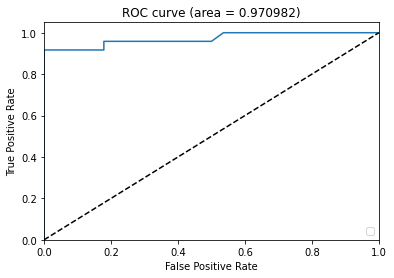

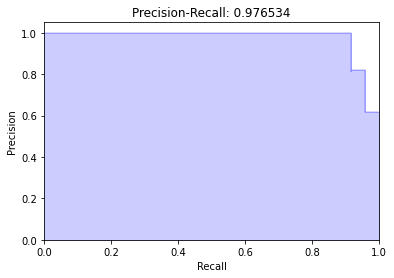

No handles with labels found to put in legend.


Confusion matrix:
 [[104   5]
 [ 10  86]]
Training AUC: 98.2511 %
Training accuracy: 92.6829 %
Test Confusion matrix:
 [[28  0]
 [ 2 22]]
Test Training AUC: 97.0982 %
Test Training accuracy: 96.1538 %
Average_precision: 0.9765 


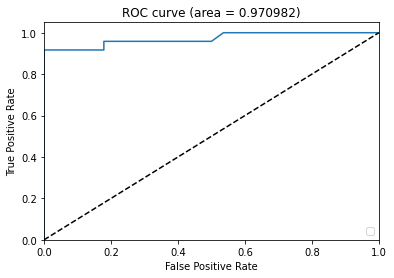

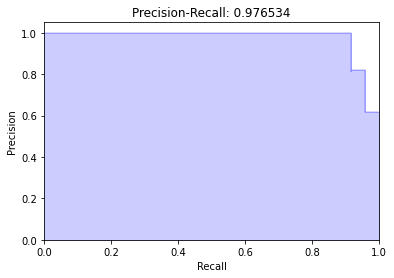


               precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       1.00      0.92      0.96        24

    accuracy                           0.96        52
   macro avg       0.97      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52

-------------END EXECUTION-------------


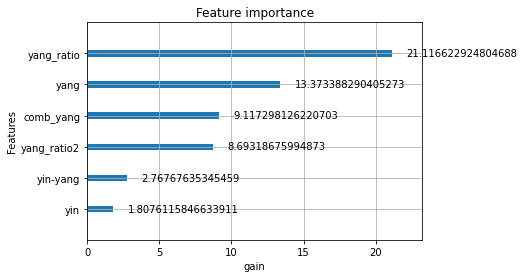

In [18]:
run_xgboost_and_calculate_auc(mod1_df,'type',
                                    plot_learning=True,
                                    plot_variables=True,
                                    plot_ROC_PR=True,
                                    plot_confusion=True)

/home/hqyone/anaconda3/envs/tf1/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
No handles with labels found to put in legend.


variables: 263, rows:257, flags:120
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
6        0.996228        0.00191       0.992724      0.009363


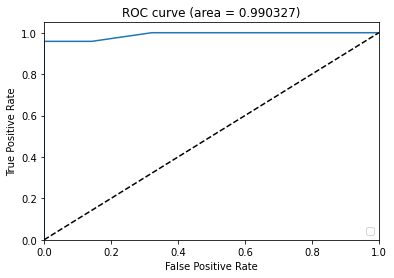

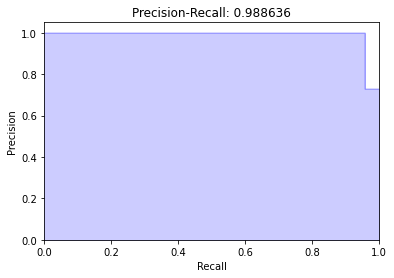

No handles with labels found to put in legend.


Confusion matrix:
 [[109   0]
 [  7  89]]
Training AUC: 99.3979 %
Training accuracy: 96.5854 %
Test Confusion matrix:
 [[28  0]
 [ 2 22]]
Test Training AUC: 99.0327 %
Test Training accuracy: 96.1538 %
Average_precision: 0.9886 


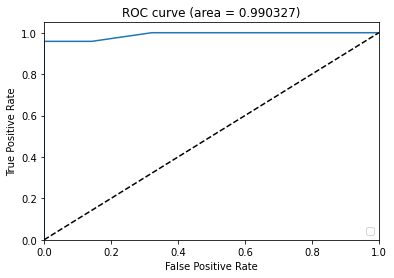

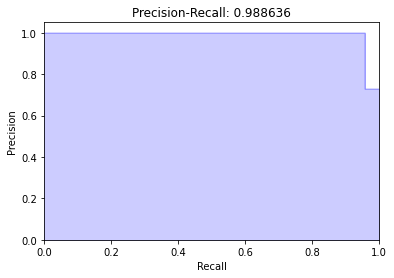


               precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       1.00      0.92      0.96        24

    accuracy                           0.96        52
   macro avg       0.97      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52

-------------END EXECUTION-------------


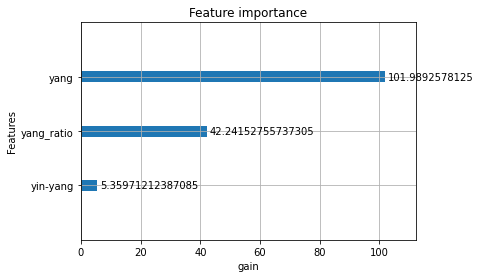

In [19]:
run_xgboost_and_calculate_auc(mod4_df,'type',
                                    plot_learning=True,
                                    plot_variables=True,
                                    plot_ROC_PR=True,
                                    plot_confusion=True)

In [7]:
mod4_df.head()

,patientID,yin,yin-yang,yang,type,yang_ratio,comb_yang,yang_ratio2
0,G:\LXG\data120jsonmodel4\18000971,9960,1,25,1,0.002504,26,0.002604
1,G:\LXG\data120jsonmodel4\00031331,9966,5,26,1,0.002601,31,0.003101
2,G:\LXG\data120jsonmodel4\00021767,9904,4,33,1,0.003320,37,0.003722
3,G:\LXG\data120jsonmodel4\135703,9942,10,41,1,0.004103,51,0.005104
4,G:\LXG\data120jsonmodel4\00031615,9904,16,43,1,0.004316,59,0.005922
